# Model Visualization Notebook

This notebook loads a trained model using Hydra/OmegaConf configuration and visualizes its outputs.

In [14]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import rootutils
from omegaconf import DictConfig, OmegaConf
import hydra
from copy import deepcopy

torch.fx.wrap('len')

# Add the project root directory to the Python path
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))
rootutils.setup_root(str(project_root), indicator=".project-root", pythonpath=True)

PosixPath('/home/yperron/code/archaeo_segment')

In [15]:
# Define paths
path = "../logs/0_paper/multiscale/C/20250303-14:05-ViT_C_XR_nR-num_register_tokens/1__8"
config_path = path+"/.hydra/config.yaml"
checkpoint_path = path+"/checkpoints/epoch_029.ckpt"
NUMREGISTER=8

# Verify paths exist
print(f"Config exists: {os.path.exists(config_path)}")
print(f"Checkpoint exists: {os.path.exists(checkpoint_path)}")

Config exists: True
Checkpoint exists: True


In [16]:
# Load the config
config = OmegaConf.load(config_path)
print("Config loaded successfully!")

Config loaded successfully!


In [17]:
# Instantiate datamodule
datamodule = hydra.utils.instantiate(config.data)
print(f"Datamodule instantiated: {type(datamodule).__name__}")

# Setup datamodule
datamodule.setup("train")

Datamodule instantiated: CityDataModule


In [18]:
# Instantiate model
model = hydra.utils.instantiate(config.model.net)
print(f"Model instantiated: {type(model).__name__}")

# Load model weights from checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
checkpoint = {k.replace('net.', ''): v for k, v in checkpoint["state_dict"].items()}
model.load_state_dict(checkpoint)
model.eval()
print("Model weights loaded successfully!")

backbone output features.shape: torch.Size([1, 256, 384])
384 16 16
self.embed_dim=384, self.downsample_factor=16, self.feature_size=16
Model instantiated: ViT_reg
Model weights loaded successfully!


In [19]:
# Get a batch of data
loader = datamodule.train_dataloader()
batch = next(iter(loader))

# The structure of the batch might vary depending on your datamodule implementation
# Adjust as needed
images, targets, meta = batch

In [20]:
# Visualization function
def visualize_sample(image, target, prediction, idx=0):
    plt.figure(figsize=(15, 5))

    # Display image
    plt.subplot(1, 3, 1)
    img = image[idx].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    # Display ground truth
    plt.subplot(1, 3, 2)
    plt.imshow(target[idx].cpu().numpy(), cmap='jet')
    plt.title("Ground Truth")
    plt.axis('off')

    # Display prediction
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[idx].argmax(dim=0).cpu().numpy(), cmap='jet')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [21]:
# Make predictions
with torch.no_grad():
    images_model = deepcopy(images)
    outputs = model(images_model)

predictions = outputs["out"]
print(f"Predictions shape: {predictions.shape}")

Predictions shape: torch.Size([32, 19, 256, 256])


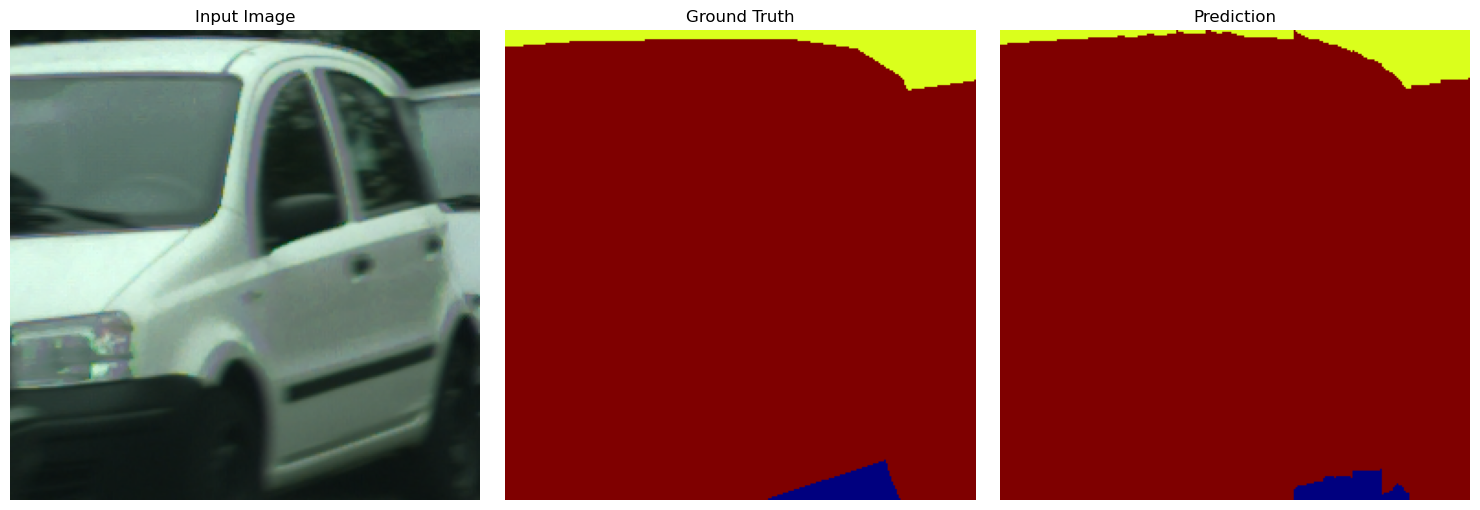

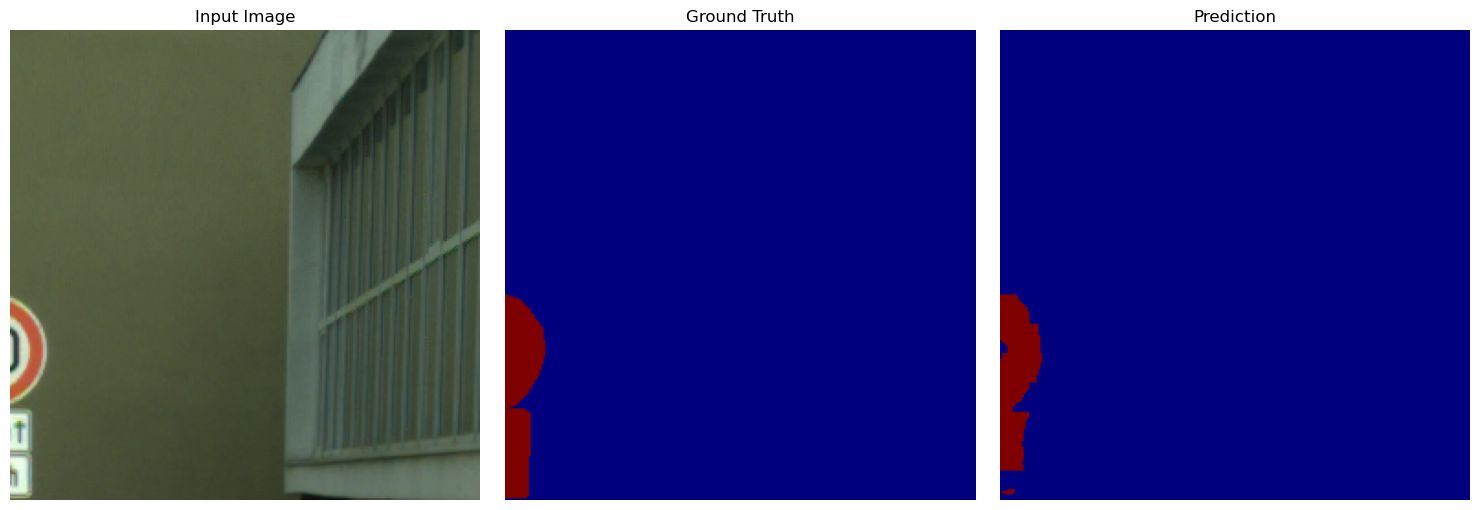

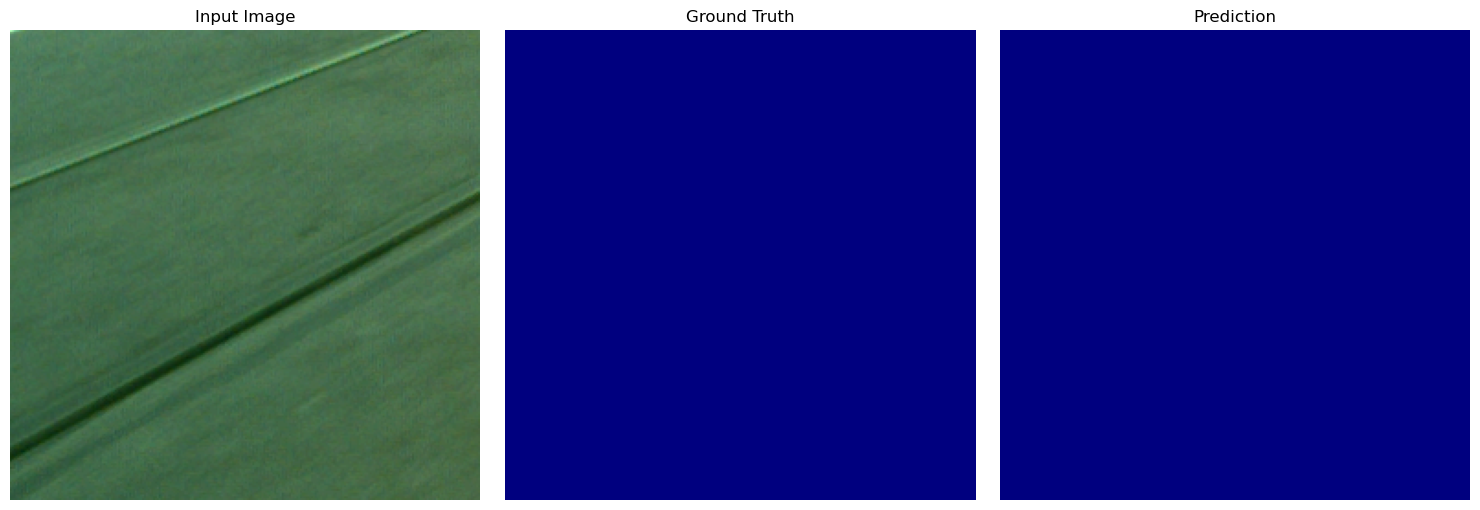

In [22]:
# Visualize a few samples
for i in range(20,23):
    visualize_sample(images[0], targets, predictions, idx=i)

## Accessing Attention Maps (for ViT models)

If you're working with a Vision Transformer model, you might want to visualize attention maps.

In [23]:
def disable_fused_attention_ViT(model):
    vit_blocks = model.model.blocks

    for block in vit_blocks:
        block.attn.fused_attn = False


disable_fused_attention_ViT(model)

In [24]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

# print(get_graph_node_names(model))

att_node_name = {f"model.blocks.{i}.attn.softmax":f"layer{i}_global" for i in range(12)} | {f"model.blocks.{i}.attn.softmax_1":f"layer{i}_local" for i in range(12)}

att_model = create_feature_extractor(model, return_nodes=att_node_name)

In [25]:
import einops

def register_attention_maps(full_attentions, num_registers=NUMREGISTER):
    registers_attention =  full_attentions[...,:num_registers,num_registers:] # (B, N, num_registers, P)
    side = int(registers_attention.shape[-1]**0.5)
    registers_attention = einops.rearrange(registers_attention, 'b n r (h w) -> b n r h w', h=side, w=side)
    mean_attention = einops.reduce(registers_attention, 'b n r h w -> r h w', 'mean')
    return mean_attention

In [26]:
# Visualization function for attention maps
def visualize_attention_maps(attention_maps, num_layers=12, figsize=(15, 20)):
    """
    Visualizes attention maps from a ViT model.

    Args:
        attention_maps: Dictionary containing attention maps
        num_layers: Number of transformer layers
        figsize: Size of the figure
    """
    plt.figure(figsize=figsize)

    # Calculate grid dimensions based on number of attention types and layers
    num_attn_types = 2  # local and global
    num_register = NUMREGISTER
    rows = num_layers
    cols = num_attn_types * num_register

    # For each layer, plot local and global attention
    for i in range(num_layers):
        for r in range(num_register):
            # Local attention
            plt.subplot(rows, cols, i*cols + r*num_attn_types + 1)
            if f'layer{i}_local' in attention_maps:
                attn = attention_maps[f'layer{i}_local'][r]
                plt.imshow(attn, cmap='viridis')
                plt.title(f'Layer {i} Reg {r} - Local Attention')
            else:
                plt.title(f'Layer {i} Reg {r} - Local Attention (Not Available)')
            plt.axis('off')

            # Global attention
            plt.subplot(rows, cols, i*cols + r*num_attn_types + 2)
            if f'layer{i}_global' in attention_maps:
                attn = attention_maps[f'layer{i}_global'][r].unsqueeze(-1)
                plt.imshow(attn, cmap='viridis')
                plt.title(f'Layer {i} Reg {r} - Global Attention')
            else:
                plt.title(f'Layer {i} Reg {r} - Global Attention (Not Available)')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Accumulate attention maps over multiple batches
accumulated_attention_maps = {f'layer{i}_local': [] for i in range(12)}
accumulated_attention_maps.update({f'layer{i}_global': [] for i in range(12)})

# Process 10 batches
num_batches = 10
batch_count = 0

model.eval()
with torch.no_grad():
    # Get batches from the train dataloader
    for batch in loader:
        if batch_count >= num_batches:
            break

        # Unpack batch
        images, targets_batch, meta = batch

        # Get attention maps
        att_out = att_model(images)

        # Store attention maps
        for layer_name, att_map in att_out.items():
            reg_att_map = register_attention_maps(att_map).detach().cpu()
            accumulated_attention_maps[layer_name].append(reg_att_map)

        batch_count += 1
        print(f"Processed batch {batch_count}/{num_batches}")

# Average attention maps across batches
averaged_attention_maps = {}
for layer_name, att_maps in accumulated_attention_maps.items():
    if att_maps:  # Check if the list is not empty
        averaged_attention_maps[layer_name] = torch.stack(att_maps, dim=0).mean(dim=0, keepdim=False)

Processed batch 1/10
Processed batch 2/10
Processed batch 3/10
Processed batch 4/10
Processed batch 5/10
Processed batch 6/10
Processed batch 7/10
Processed batch 8/10
Processed batch 9/10
Processed batch 10/10


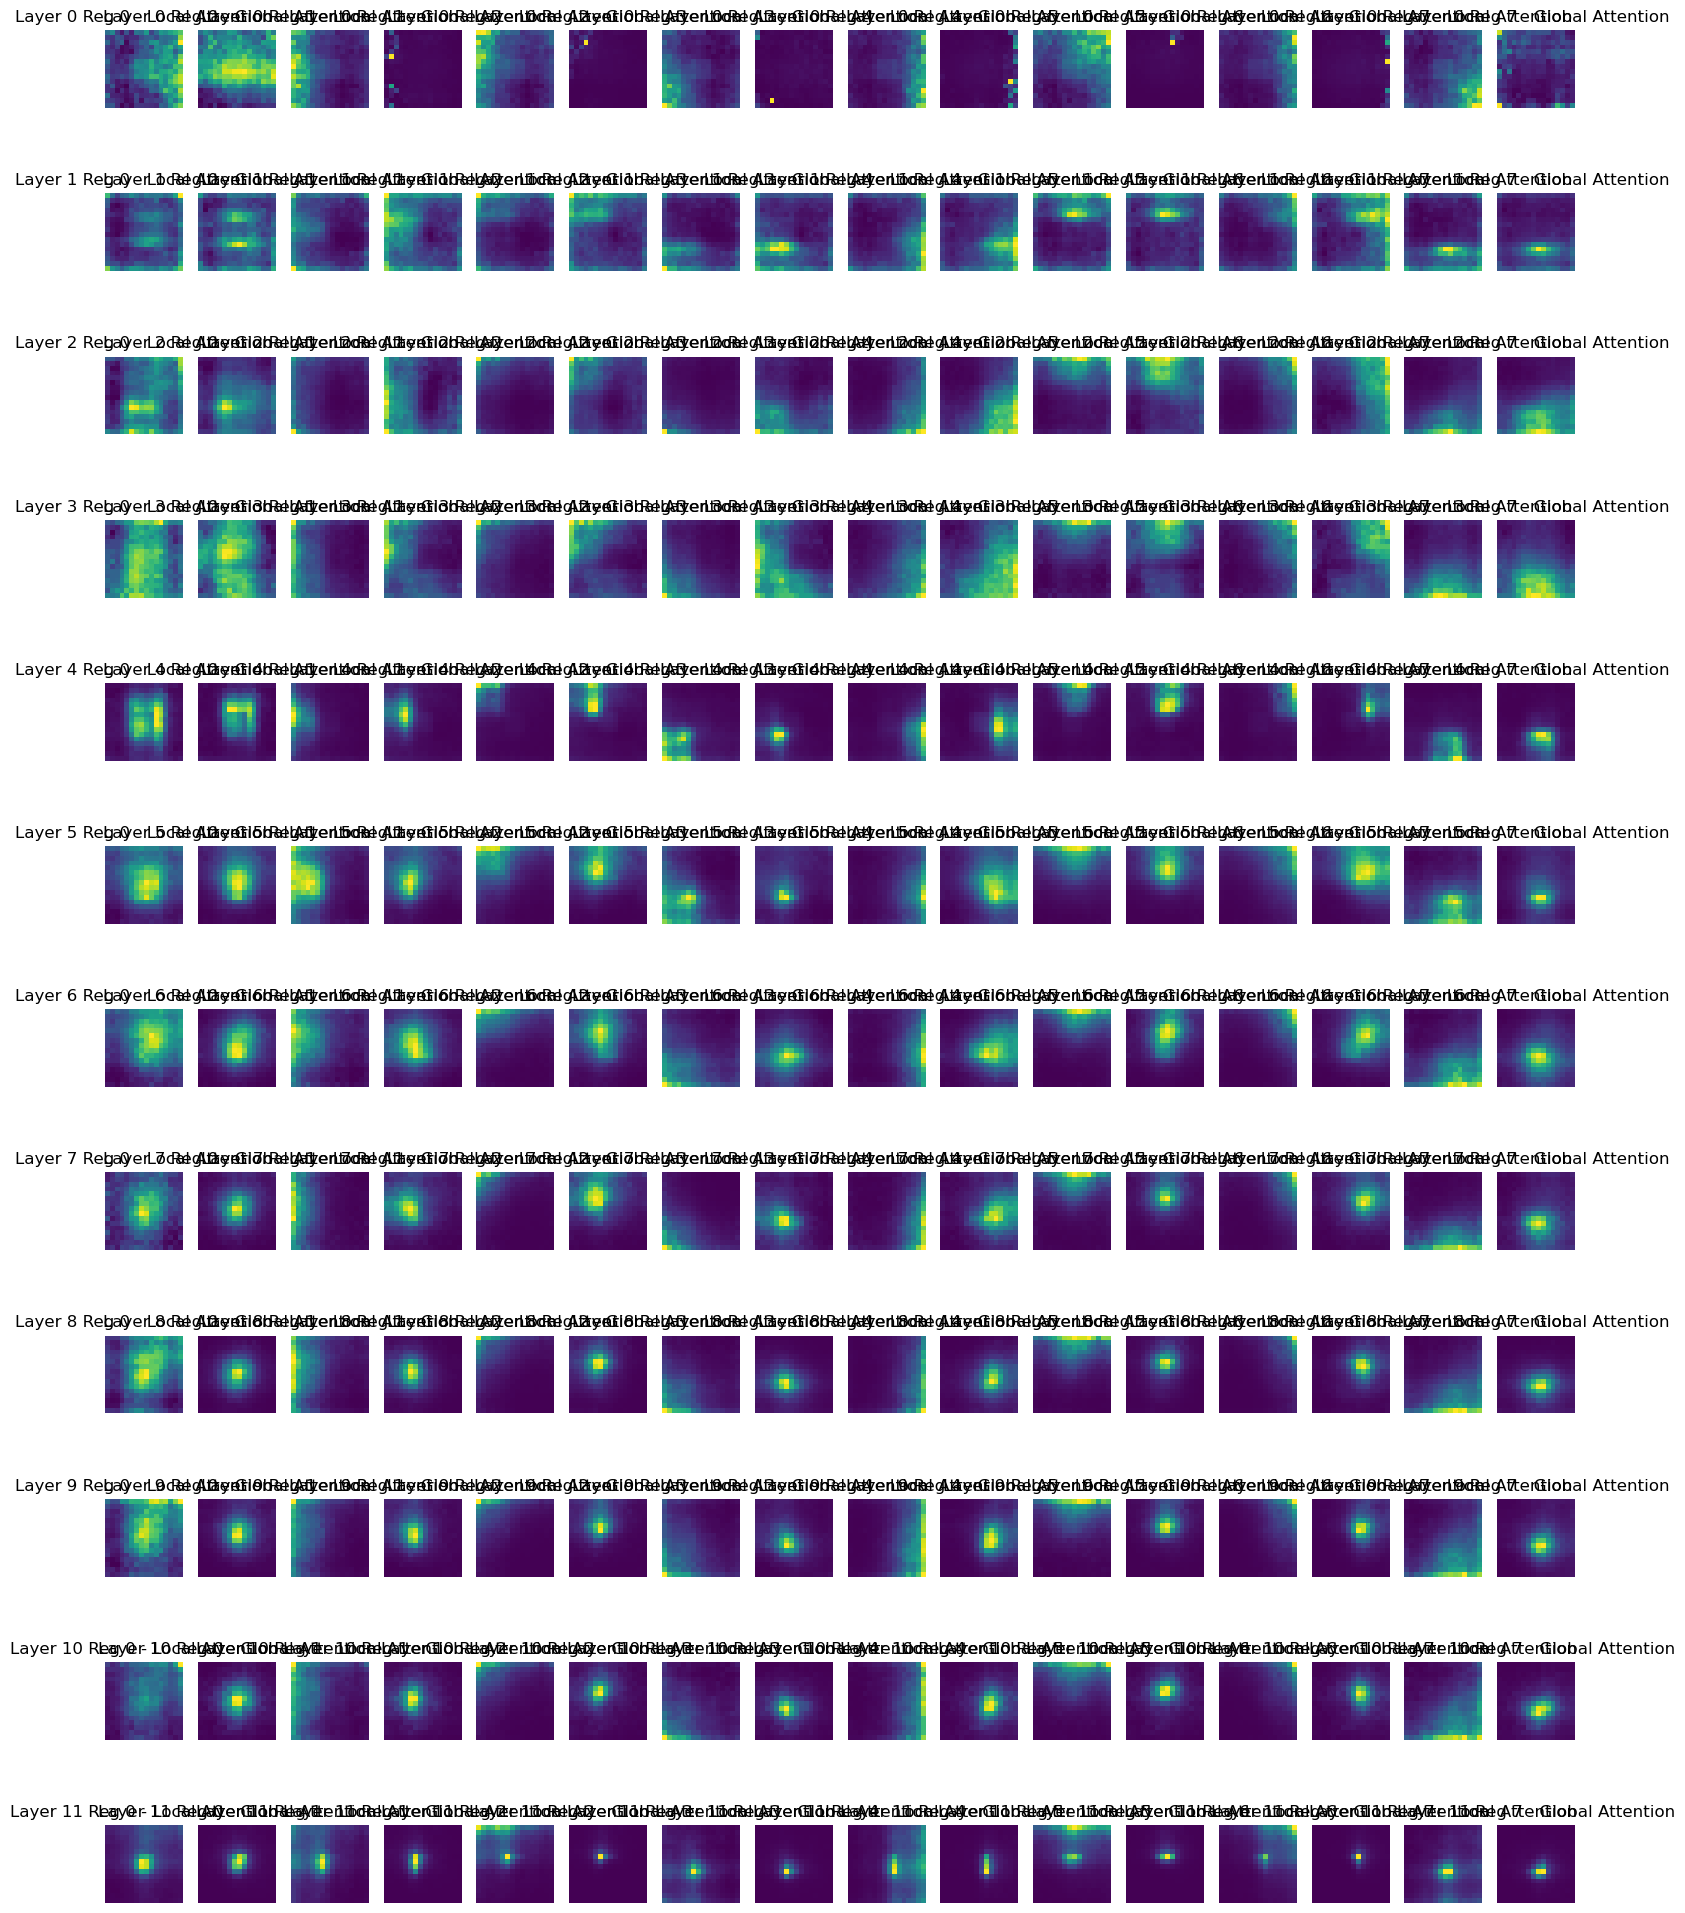

In [27]:
# Visualize the averaged attention maps
visualize_attention_maps(averaged_attention_maps)

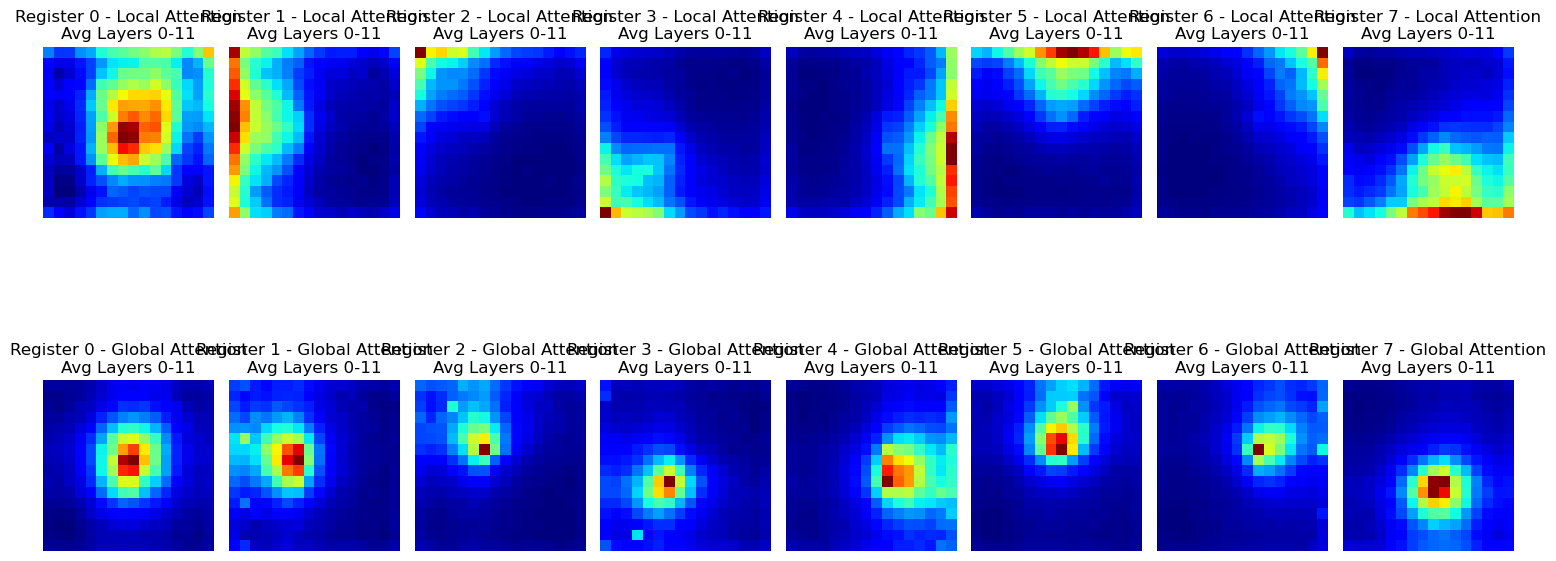

: 

In [ ]:
import os

# Function to visualize attention maps over multiple layers
def visualize_attention_layers_average(attention_maps, num_layers=12, figsize=(15, 8), start_layer=0, end_layer=None, upsample=False):
    """
    Visualizes attention maps from a ViT model by averaging across layers.

    Args:
        attention_maps: Dictionary containing attention maps
        num_layers: Total number of transformer layers
        figsize: Size of the figure
        start_layer: First layer to include in average
        end_layer: Last layer to include in average (None means all remaining layers)
    """
    if end_layer is None:
        end_layer = num_layers

    plt.figure(figsize=figsize)
    num_register = NUMREGISTER
    # Average attention maps across specified layers
    avg_local_maps = []
    avg_global_maps = []

    for r in range(num_register):
        # Collect local attention maps across layers
        local_maps = []
        global_maps = []

        for i in range(start_layer, end_layer):
            if f'layer{i}_local' in attention_maps:
                local_maps.append(attention_maps[f'layer{i}_local'][r])
            if f'layer{i}_global' in attention_maps:
                global_maps.append(attention_maps[f'layer{i}_global'][r])
        # Average if we have maps
        if local_maps:
            local_maps = torch.stack(local_maps).mean(0)
        else:
            local_maps = None
        if global_maps:
            global_maps = torch.stack(global_maps).mean(0)
        else:
            global_maps = None

        #bilinear upsempling to 256x256
        if upsample:
            if local_maps is not None:
                local_maps = torch.nn.functional.interpolate(local_maps[None,None,...], size=(upsample, upsample), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
            if global_maps is not None:
                global_maps =  torch.nn.functional.interpolate(global_maps[None,None,...], size=(upsample, upsample), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

        if local_maps is not None:
            avg_local_maps.append(local_maps)
        if global_maps is not None:
            avg_global_maps.append(global_maps)

    # Plot averaged attention maps
    for r in range(num_register):
        plt.subplot(2, num_register, r + 1)
        if avg_local_maps:
            plt.imshow(avg_local_maps[r], cmap='jet')
            plt.title(f'Register {r} - Local Attention\nAvg Layers {start_layer}-{end_layer-1}')
        else:
            plt.title(f'Register {r} - Local Attention\n(Not Available)')
        plt.axis('off')

        plt.subplot(2, num_register, r + num_register + 1)
        if avg_global_maps:
            plt.imshow(avg_global_maps[r], cmap='jet')
            plt.title(f'Register {r} - Global Attention\nAvg Layers {start_layer}-{end_layer-1}')
        else:
            plt.title(f'Register {r} - Global Attention\n(Not Available)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Plot the attention maps as a png (one at a time without title)
    # Make sure the directory exists
    os.makedirs('att_map', exist_ok=True)

    for r in range(num_register):
        # Local attention map
        if len(avg_local_maps) > 0:
            fig = plt.figure(frameon=False)
            fig.set_size_inches(5, 5)
            ax = plt.Axes(fig, [0, 0, 1, 1])
            ax.set_axis_off()
            fig.add_axes(ax)
            ax.imshow(avg_local_maps[r], cmap='jet')
            plt.savefig(f'att_map/local_attention_register_{r}.png', bbox_inches='tight', pad_inches=0)
            plt.close(fig)

        # Global attention map
        if len(avg_global_maps) > 0:
            fig = plt.figure(frameon=False)
            fig.set_size_inches(5, 5)
            ax = plt.Axes(fig, [0, 0, 1, 1])
            ax.set_axis_off()
            fig.add_axes(ax)
            ax.imshow(avg_global_maps[r], cmap='jet')
            plt.savefig(f'att_map/global_attention_register_{r}.png', bbox_inches='tight', pad_inches=0)
            plt.close(fig)

# Call the function to visualize averaged attention maps
# Early layers (0-3)
# visualize_attention_layers_average(averaged_attention_maps, start_layer=0, end_layer=4)

# Middle layers (4-7)
# visualize_attention_layers_average(averaged_attention_maps, start_layer=4, end_layer=8)

# Late layers (8-11)
# visualize_attention_layers_average(averaged_attention_maps, start_layer=8, end_layer=12)

# All layers average
visualize_attention_layers_average(averaged_attention_maps, start_layer=0, end_layer=12, upsample=False)